In [ ]:
!git clone -b janina https://github.com/inttx/DLAM_SealedSurfaces.git
%cd DLAM_SealedSurfaces

In [1]:
!pip install -r requirements.txt
%cd src


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
/home/janina/PycharmProjects/DLAM_SealedSurfaces/src


In [2]:
from torch.utils.data import DataLoader
from torch import nn
from torch.optim import AdamW

from settings import *
from dataset import PotsdamDataset, get_data_loaders
from models import custom_resnet18, baseline_deeplabv3plus_resnet101, seg_former
from train import train_loop

In [3]:
try:
    import os
    import shutil
    from google.colab import drive
    MOUNTPOINT = '/content/drive/'
    drive.mount(MOUNTPOINT)

    IMAGE_PATH = os.path.join(MOUNTPOINT, 'MyDrive', 'DLAM', '2_Ortho_RGB') # TODO adjust to your path
    LABEL_PATH = os.path.join(MOUNTPOINT, 'MyDrive', 'DLAM', '5_Labels_all') # TODO adjust to your path

    SAVE_PATH = MOUNTPOINT + 'MyDrive/DLAM/models/'
    PLOT_PATH = MOUNTPOINT + 'MyDrive/DLAM/plots/'
except:
    IMAGE_PATH = '../data/2_Ortho_RGB' # TODO adjust to your path
    LABEL_PATH = '../data/5_Labels_all' # TODO adjust to your path
    SAVE_PATH = '../models/'
    PLOT_PATH = '../plots/'
os.makedirs(SAVE_PATH, exist_ok=True)
os.makedirs(PLOT_PATH, exist_ok=True)

In [4]:
# Hyperparameters
patch_size = 250
stride = 250
batch_size = 8
num_epochs = 10
lr = 0.001
weight_decay = 1e-2

# Train resnet18

Opening image files: 100%|██████████| 38/38 [00:00<00:00, 1019.62it/s]

Opening label files: 100%|██████████| 38/38 [00:00<00:00, 1228.11it/s]


Epoch 1 / 10: Average loss = 37938.9951


Epoch 1 average validation loss: 41650.4658


Epoch 2 / 10: Average loss = 37434.5059


Epoch 2 average validation loss: 41148.7168


Epoch 3 / 10: Average loss = 36913.7393


Epoch 3 average validation loss: 40616.1484


Epoch 4 / 10: Average loss = 36423.3257


Epoch 4 average validation loss: 40052.1279


Epoch 5 / 10: Average loss = 35903.1382


Epoch 5 average validation loss: 39497.7461


Epoch 6 / 10: Average loss = 35429.4346


Epoch 6 average validation loss: 38937.6279


Epoch 7 / 10: Average loss = 34968.6826


Epoch 7 average validation loss: 38412.7031


Epoch 8 / 10: Average loss = 34462.9258


Epoch 8 average validation loss: 37868.8945


Epoch 9 / 10: Average loss = 34034.3657


Epoch 9 average validation loss: 37363.7236


Epoch 10 / 10: Average loss = 33599.5757


Epoch 10 average validation loss: 36868.3369
Model saved to ../models/resnet18.pth!


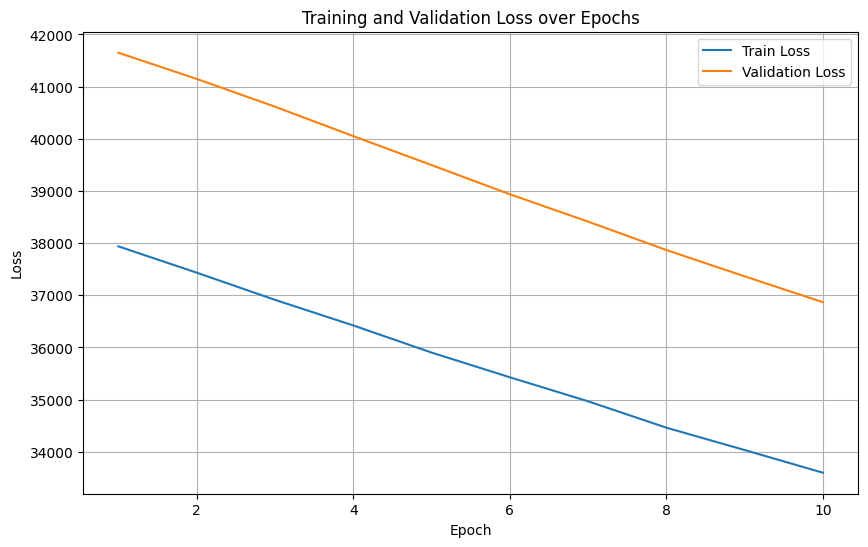

In [5]:
dataset = PotsdamDataset(IMAGE_PATH, LABEL_PATH, patch_size=patch_size, stride=stride, device=DEVICE, no_color_labels=False)
train_loader, val_loader, test_loader = get_data_loaders(dataset, [0.8, 0.1, 0.1] ,batch_size)

model = custom_resnet18(patch_size=patch_size, device=DEVICE)
loss_fn = nn.MSELoss()
optimizer = AdamW(model.parameters(), lr=lr)

train_loop(train_loader=train_loader, val_loader=val_loader, model=model, loss_fn=loss_fn, optimizer=optimizer, num_epochs=num_epochs, device=DEVICE, save_path=SAVE_PATH + 'resnet18.pth', model_type='ResNet18', plot_path=PLOT_PATH + 'resnet18.png')

# Train DeepLabV3 resnet101 baseline

Opening image files: 100%|██████████| 38/38 [00:00<00:00, 1560.18it/s]

Opening label files: 100%|██████████| 38/38 [00:00<00:00, 4841.98it/s]


Epoch 1 / 10: Average loss = 3.6224


Epoch 1 average validation loss: 31.5161


Epoch 2 / 10: Average loss = 2.4287


Epoch 2 average validation loss: 100.0216


Epoch 3 / 10: Average loss = 1.7142


Epoch 3 average validation loss: 32.9919


Epoch 4 / 10: Average loss = 1.5023


Epoch 4 average validation loss: 64.1293


Epoch 5 / 10: Average loss = 1.2971


Epoch 5 average validation loss: 10.7027


Epoch 6 / 10: Average loss = 1.2147


Epoch 6 average validation loss: 4.0625


Epoch 7 / 10: Average loss = 0.9417


Epoch 7 average validation loss: 2.8686


Epoch 8 / 10: Average loss = 0.7904


Epoch 8 average validation loss: 2.0183


Epoch 9 / 10: Average loss = 0.6415


Epoch 9 average validation loss: 1.7644


Epoch 10 / 10: Average loss = 0.7798


Epoch 10 average validation loss: 1.8481
Model saved to ../models/deeplabv3_resnet101.pth!


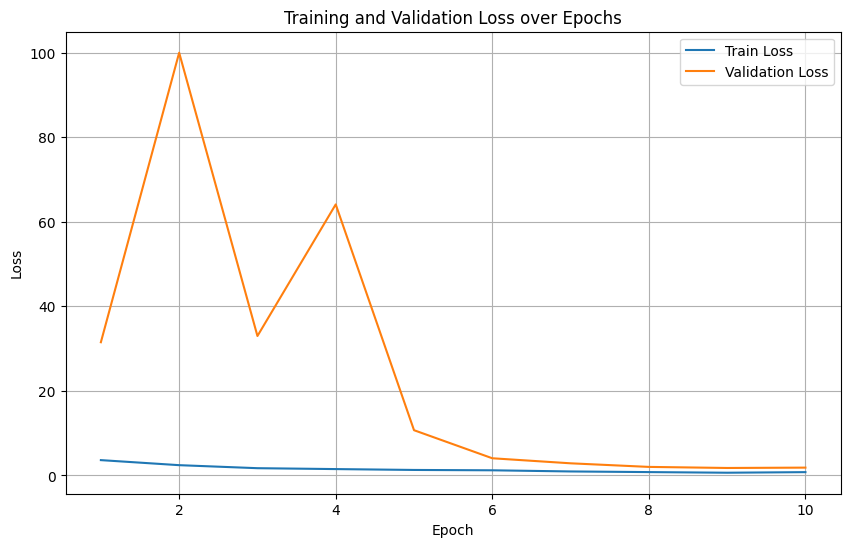

In [6]:
dataset = PotsdamDataset(IMAGE_PATH, LABEL_PATH, patch_size=patch_size, stride=stride, device=DEVICE, no_color_labels=True)
train_loader, val_loader, test_loader = get_data_loaders(dataset, [0.8, 0.1, 0.1] ,batch_size)

model = baseline_deeplabv3plus_resnet101(num_classes=6, device=DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=lr)

train_loop(train_loader=train_loader, val_loader=val_loader, model=model, loss_fn=loss_fn, optimizer=optimizer, num_epochs=num_epochs, device=DEVICE, save_path=SAVE_PATH + 'deeplabv3_resnet101.pth', model_type='DeepLabV3', plot_path=PLOT_PATH + 'deeplabv3_resnet101.png')

# Train SegFormer

Building index (rows): 100%|██████████| 24/24 [00:00<00:00, 115307.33it/s]
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([6]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([6, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Opening image files: 100%|██████████| 38/38 [00:00<00:00, 1051.68it/s]

Opening label files: 100%|██████████| 38/38 [00:00<00:00, 4716.19it/s]


Epoch 1 / 10: Average loss = 1.8133


Epoch 1 average validation loss: 1.7527


Epoch 2 / 10: Average loss = 1.4956


Epoch 2 average validation loss: 1.9436


Epoch 3 / 10: Average loss = 1.3628


Epoch 3 average validation loss: 2.0884


Epoch 4 / 10: Average loss = 1.3117


Epoch 4 average validation loss: 1.4535


Epoch 5 / 10: Average loss = 1.1595


Epoch 5 average validation loss: 1.3592


Epoch 6 / 10: Average loss = 1.0898


Epoch 6 average validation loss: 1.3682


Epoch 7 / 10: Average loss = 0.9626


Epoch 7 average validation loss: 1.4673


Epoch 8 / 10: Average loss = 0.9362


Epoch 8 average validation loss: 1.3425


Epoch 9 / 10: Average loss = 0.8478


Epoch 9 average validation loss: 1.2630


Epoch 10 / 10: Average loss = 0.7849


Epoch 10 average validation loss: 1.3415
Model saved to ../models/segformer.pth!


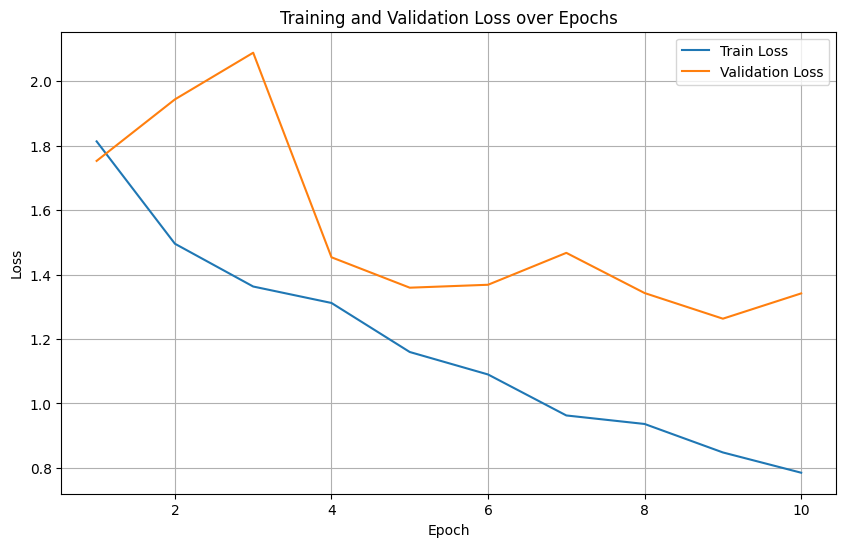

In [7]:
dataset = PotsdamDataset(IMAGE_PATH, LABEL_PATH, patch_size=patch_size, stride=stride, device=DEVICE, no_color_labels=True)
train_loader, val_loader, test_loader = get_data_loaders(dataset, [0.8, 0.1, 0.1] ,batch_size)

model = seg_former(num_classes=6, device=DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

train_loop(train_loader=train_loader, val_loader=val_loader, model=model, loss_fn=loss_fn, optimizer=optimizer, num_epochs=num_epochs, device=DEVICE, save_path=SAVE_PATH + 'segformer.pth', model_type='SegFormer', plot_path=PLOT_PATH + 'segformer.png')